In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage, signal, interpolate, linalg
import utilities
import pyHREBSD
import rotations

%matplotlib widget

In [2]:
up2 = "E:/SiGe/ScanA.up2"
ang = "E:/SiGe/ScanA.ang"
pixel_size = 13.0  # The pixel size in um
Nxy = (2048, 2048)  # The number of pixels in the x and y directions on the detector
x0 = (0)  # The location of the reference point
DoG_sigmas = (1.0, 20.0)  # The sigmas for the difference of Gaussians filter

# Read in data
pat_obj, ang_data = utilities.get_scan_data(up2, ang, Nxy, pixel_size, 1)

# Read in data
pats = utilities.get_patterns(pat_obj, (0, 50, 85))
pats[pats <= np.percentile(pats, 1)] = np.percentile(pats, 50)

# utilities.test_bandpass(pats[0], "./", window_size=256)
pats = utilities.process_patterns(pats, equalize=True, dog_sigmas=(1.0, 30.0))

Reading patterns:   0%|          | 0/3 [00:00<?, ?pats/s]

Processing patterns:   0%|          | 0/1 [00:00<?, ?batches/s]

c:\Users\lambj\miniconda3\envs\hrebsd\Lib\site-packages\kornia\filters\filter.py:129: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  output = F.conv2d(input, tmp_kernel, groups=tmp_kernel.size(0), padding=0, stride=1)


In [15]:
### Initial guess ###
p0 = pyHREBSD.get_initial_guess(pats[0], pats, ang_data.pc) + 0.0
print(p0)

Measurements: (-0.0, -0.0, -0.0)
Mod shifts: (0.0, 0.0, -0.0)
Omegas: (0.0, -0.0, -0.0)
Rr: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Rr: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


0.17453292519943295
Initial guess: (-0.0152, -0.1736, 0.0000, 0.1736, -0.0152, 0.0000, 0.0000, 0.0000)
Measurements: (-40.0, 21.0, -0.17180584)
Mod shifts: (-92.8979, 37.25557, -0.17180584)
Omegas: (0.02265017, 0.05642858, -0.17180584)
Rr: [[ 0.98370939  0.12326823  0.13084628]
 [-0.11962236  0.99218824 -0.03539767]
 [-0.13418754  0.01916886  0.99077055]]
Rr: [[ 0.99287  0.12442  0.13207]
 [-0.12074  1.00143 -0.03573]
 [-0.13544  0.01935  1.     ]]
Fixing guess:  (-0.0234, 0.1250, -180.4702, -0.1444, -0.0015, 42.4015, 0.0001, -0.0000)
(1024, 1024) (1024, 1024) (1024, 1024)


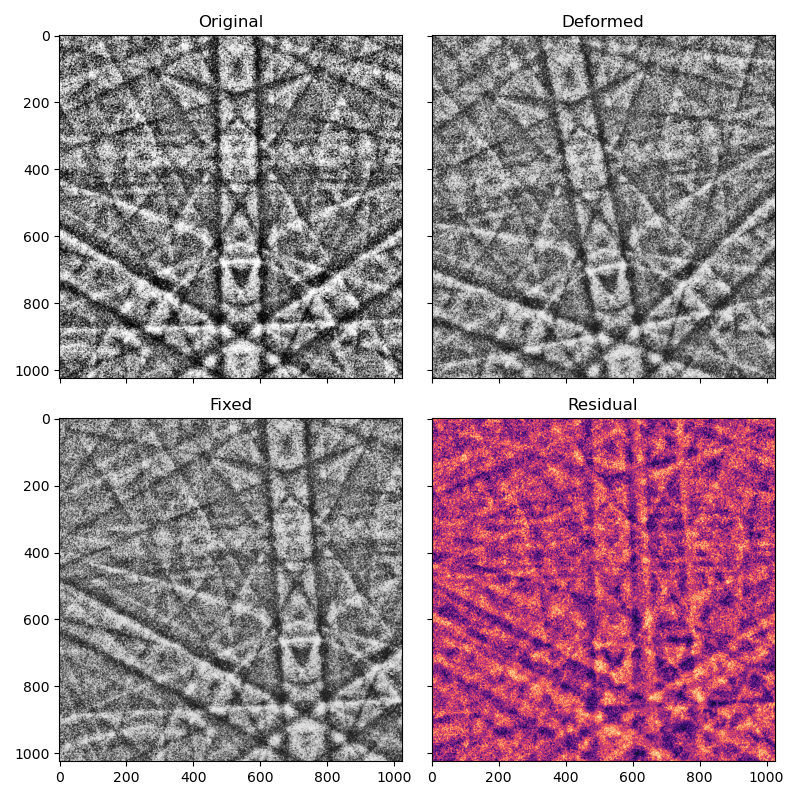

In [3]:
### Round trip deform and undeform with residuals ###
print(10 * np.pi/180)
p = pyHREBSD.shift_to_homography_partial(0.0, 0.0, 10 * np.pi/180)
print(f"Initial guess: ({p[0]:.4f}, {p[1]:.4f}, {p[2]:.4f}, {p[3]:.4f}, {p[4]:.4f}, {p[5]:.4f}, {p[6]:.4f}, {p[7]:.4f})")
subset_slice = (slice(512, -512), slice(512, -512))
# subset_slice = (slice(None), slice(None))
T = pats[1]
T_deformed = pyHREBSD.deform_image(T, p, ang_data.pc, kx=5, ky=5)

# p = pyHREBSD.get_initial_guess(T, T_deformed, ang_data.pc)
p = pyHREBSD._get_gcc_guesses(T, T_deformed.reshape(-1, *T_deformed.shape), ang_data.pc, 30, 512)
print(f"Fixing guess:  ({p[0]:.4f}, {p[1]:.4f}, {p[2]:.4f}, {p[3]:.4f}, {p[4]:.4f}, {p[5]:.4f}, {p[6]:.4f}, {p[7]:.4f})")
T_fixed = pyHREBSD.deform_image(T_deformed, p, ang_data.pc, subset_slice=subset_slice, kx=5, ky=5)

print(T[subset_slice].shape, T_deformed[subset_slice].shape, T_fixed.shape)

original = pyHREBSD.normalize(T[subset_slice])
deformed = pyHREBSD.normalize(T_deformed[subset_slice])
fixed = pyHREBSD.normalize(T_fixed)
residual = original - fixed

fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
ax[0, 0].imshow(original, cmap='gray')
ax[0, 0].set_title('Original')
ax[0, 1].imshow(deformed, cmap='gray')
ax[0, 1].set_title('Deformed')
ax[1, 0].imshow(fixed, cmap='gray')
ax[1, 0].set_title('Fixed')
ax[1, 1].imshow(residual, cmap='magma')
ax[1, 1].set_title('Residual')
plt.tight_layout()
plt.show()

In [ ]:
### Test deforming a pattern using a homography ###
T = pats[2].astype(np.float64)
print(T.min(), T.max())
subset_slice = (slice(None), slice(None))

plt.close('all')
fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)

p = np.array([-0.002, 0.0, 3.0, 0.0, -0.001, -10.0, 0.0, 0.0])
pc = np.array([T.shape[1] / 2, T.shape[0] / 2, 0])
T_spline, xi = target_precompute(T, subset_slice=subset_slice)

t_deformed = deform(xi, T_spline, p)
t_deformed = normalize(t_deformed)
t = normalize(T)
print(t.min(), t.max())
ax[0, 0].imshow(t, cmap='gray')
ax[0, 0].scatter(*pc[:2], c='r', s=10, marker='x')
ax[0, 0].set_title("Target")
ax[0, 1].imshow(t_deformed.reshape(R[subset_slice].shape), cmap='gray')
ax[0, 1].scatter(*pc[:2], c='r', s=10, marker='x')
ax[0, 1].set_title("Deformed Target")

p = np.array([-0.005, 0.0, 3.0, 0.0, -0.001, -10.0, 0.0, 0.0])
pc = np.array([int(0.5 * 2048), int(0.45 * 2048), 0])
T_spline, xi = target_precompute(T, PC, subset_slice=subset_slice)

t_deformed = deform(xi, T_spline, p)
t_deformed = normalize(t_deformed)
t = normalize(T)
ax[1, 0].imshow(t, cmap='gray')
ax[1, 0].scatter(*pc[:2], c='r', s=10, marker='x')
ax[1, 0].set_title("Target")
ax[1, 1].imshow(t_deformed.reshape(R[subset_slice].shape), cmap='gray')
ax[1, 1].scatter(*pc[:2], c='r', s=10, marker='x')
ax[1, 1].set_title("Deformed Target")

plt.tight_layout()
plt.show()

In [ ]:
### Test the IC-GN algorithm ###
R = pats[0].astype(np.float64)
subset_slice = (slice(512, -512), slice(512, -512))
subset_slice = (slice(10, -10), slice(10, -10))

# Precompute values for the reference subset
r, dr_tilde, NablaR_dot_Jac, H, xi = reference_precompute(R, subset_slice, PC)

i = 2
T = pats[i].astype(np.float64)

conv_tol = 1e-2
max_iter = 100

p = p0[i].copy()
# p = np.array([-0.005, 0.0, 3.0, 0.0, -0.001, -10.0, 0.0, 0.0])
# p = np.array([0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# Precompute the target subset
T_spline, _ = target_precompute(T, PC)

# Run the iterations
num_iter = 0
pnorms = []
residuals = []
while True:
    # Warp the target subset
    num_iter += 1
    t_deformed = deform(xi, T_spline, p)
    t_deformed = normalize(t_deformed)

    # Compute the residuals
    e = r - t_deformed
    residuals.append(np.abs(e).mean())

    # Copmute the gradient of the correlation criterion
    dC_IC_ZNSSD = 2 / dr_tilde * np.matmul(e, NablaR_dot_Jac.T)  # 8x1

    # Find the deformation incriment, delta_p, by solving the linear system H.dot(delta_p) = -dC_IC_ZNSSD using the Cholesky decomposition
    c, lower = linalg.cho_factor(H)
    dp = linalg.cho_solve((c, lower), -dC_IC_ZNSSD.reshape(-1, 1))[:, 0]
    # Do it the slow way
    # dp = np.linalg.solve(H, -dC_IC_ZNSSD)

    # Update the homography
    norm = dp_norm(dp, xi)
    Wp = W(p)
    Wp = Wp.dot(np.linalg.inv(W(dp)))
    Wp = Wp / Wp[2, 2]
    p = np.array([Wp[0, 0] - 1, Wp[0, 1], Wp[0, 2],
                  Wp[1, 0], Wp[1, 1] - 1, Wp[1, 2],
                  Wp[2, 0], Wp[2, 1]])

    # Save out the images for debugging
    R_image = r.reshape(int(np.sqrt(r.size)), int(np.sqrt(r.size)))
    T_image = t_deformed.reshape(int(np.sqrt(t_deformed.size)), int(np.sqrt(t_deformed.size)))
    e_image = e.reshape(int(np.sqrt(e.size)), int(np.sqrt(e.size)))
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(R_image, cmap='gray')
    ax[0].set_title("Reference")
    ax[1].imshow(T_image, cmap='gray')
    ax[1].set_title("Deformed Target")
    im = ax[2].imshow(e_image, cmap='gray')
    ax[2].set_title("Residuals")
    cax = plt.axes([0.92, 0.1, 0.01, 0.2])
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    plt.savefig(f"gif/{num_iter}.png")
    plt.close(fig)
    pnorms.append(norm)
    print(f"Iteration {num_iter}: Norm = {norm:.2e}", "\n\tp: ({:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f})".format(*p), "dp: ({:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f})".format(*dp))
                        
    # Check for convergence
    if norm < conv_tol or num_iter == max_iter:
        break

if num_iter == max_iter:
    print(f"Warning: Maximum number of iterations reached!")

In [ ]:
p[np.abs(p) < 1e-9] = 0
print(deformation_to_stress_strain(homography_to_elastic_deformation(p, PC), tol=1e-4)[0])

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
axt = ax.twinx()
ax.plot(pnorms)
axt.plot(residuals, color='red')
ax.set_yscale('log')
axt.set_ylabel('Residuals', color='red')
plt.tight_layout()
plt.show()


In [ ]:
def calc_strain(reference_pattern, target_pattern, pattern_center, p, subset_slice):
    r, dr_tilde, NablaR_dot_Jac, H, xi = reference_precompute(reference_pattern, subset_slice, pattern_center)
    T_spline = target_precompute(target_pattern, pattern_center)
        
    num_iter = 0
    pnorms = []
    residuals = []
    while True:
        # Warp the target subset
        num_iter += 1
        t_deformed = deform(xi, T_spline, p)
        t_deformed = normalize(t_deformed)

        # Compute the residuals
        e = r - t_deformed
        residuals.append(np.abs(e).mean())

        # Copmute the gradient of the correlation criterion
        dC_IC_ZNSSD = 2 / dr_tilde * np.matmul(e, NablaR_dot_Jac.T)  # 8x1

        # Find the deformation incriment, delta_p, by solving the linear system H.dot(delta_p) = -dC_IC_ZNSSD using the Cholesky decomposition
        c, lower = linalg.cho_factor(H)
        dp = linalg.cho_solve((c, lower), -dC_IC_ZNSSD.reshape(-1, 1))[:, 0]

        # Update the homography
        norm = dp_norm(dp, xi)
        Wp = W(p)
        Wp = Wp.dot(np.linalg.inv(W(dp)))
        Wp = Wp / Wp[2, 2]
        p = np.array([Wp[0, 0] - 1, Wp[0, 1], Wp[0, 2],
                    Wp[1, 0], Wp[1, 1] - 1, Wp[1, 2],
                    Wp[2, 0], Wp[2, 1]])

        # Check for convergence
        if norm < conv_tol or num_iter == max_iter:
            break

    if num_iter == max_iter:
        print(f"Warning: Maximum number of iterations reached!")

    strain = deformation_to_stress_strain(homography_to_elastic_deformation(p, pattern_center))[0]
    return calculate_von_mises_strain(strain)


def calculate_von_mises_strain(strain_tensor):
    # Extract strain components
    eps_xx, eps_yy, eps_zz = np.diag(strain_tensor)
    eps_xy, eps_yz, eps_zx = strain_tensor[0, 1], strain_tensor[1, 2], strain_tensor[2, 0]

    # Calculate hydrostatic strain
    hydrostatic_strain = (eps_xx + eps_yy + eps_zz) / 3

    # Calculate deviatoric strain tensor
    deviatoric_strain = strain_tensor - hydrostatic_strain * np.eye(3)

    # Calculate second invariant of deviatoric strain tensor
    J2 = 0.5 * (deviatoric_strain[0, 0]**2 + deviatoric_strain[1, 1]**2 + deviatoric_strain[2, 2]**2) + \
         deviatoric_strain[0, 1]**2 + deviatoric_strain[1, 2]**2 + deviatoric_strain[2, 0]**2

    # Calculate von Mises equivalent strain
    von_mises_strain = np.sqrt(2/3 * J2)

    return von_mises_strain


def monte_carlo_optimization(reference_pattern, target_pattern, initial_center, num_iterations, step_size, p0, subset_slice):
    best_center = initial_center
    best_strain = calc_strain(reference_pattern, target_pattern, best_center, p0, subset_slice)

    current_center = best_center
    current_strain = best_strain

    for i in range(num_iterations):
        # Generate a new candidate center by adding random perturbations to the current center
        candidate_center = current_center + np.around(np.random.uniform(-step_size, step_size, size=len(current_center)), 4)
        candidate_center[2] = initial_center[2]

        # Calculate the strain using the candidate center
        candidate_strain = calc_strain(reference_pattern, target_pattern, candidate_center, p0, subset_slice)

        # Accept the candidate center if it improves the strain
        if candidate_strain < current_strain:
            current_center = candidate_center
            current_strain = candidate_strain

        # Update the best center if the current strain is better than the best strain
        if current_strain < best_strain:
            best_center = current_center
            best_strain = current_strain

        # Print the progress every 100 iterations
        print(f"Iteration {i + 1}: Best Strain = {best_strain}")

    return best_center, best_strain


best_pc, best_strain = monte_carlo_optimization(pats[0], pats[2], PC, 25, 0.02, p0[2], (slice(512, 1536), slice(512, 1536)))
print("Original Pattern Center: ({},{},{})".format(PC[0], PC[1], PC[2]))
print("Best Pattern Center: ({:.4f},{:.4f},{:.4f})".format(best_pc[0], best_pc[1], best_pc[2]))
print(f"Best Von Mises Strain: {best_strain}")

In [ ]:
print(PC)

In [ ]:
R = pats[0]
subset_slice = (slice(512, -512), slice(512, -512))

ii = np.arange(R.shape[0]) - (R.shape[0] / 2 + PC[1])
jj = np.arange(R.shape[1]) - (R.shape[1] / 2 + PC[0])
II, JJ = np.meshgrid(ii, jj, indexing="ij")
xi = np.array([II[subset_slice].flatten(), JJ[subset_slice].flatten()])

# Compute the intensity gradients of the subset
spline = interpolate.RectBivariateSpline(ii, jj, R, kx=5, ky=5)
r = spline(xi[0], xi[1], grid=False).reshape(R[subset_slice].shape)

r_d1 = deform(xi, spline, np.array([0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0])).reshape(R[subset_slice].shape)
r_d2 = deform(xi, spline, np.array([0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 0.0, 0.0])).reshape(R[subset_slice].shape)

plt.close('all')
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax = ax.flatten()
ax[0].imshow(R, cmap='gray')
ax[0].grid()
ax[1].imshow(r, cmap='gray')
ax[1].grid()
ax[2].imshow(r_d1, cmap='gray')
ax[2].grid()
ax[2].set_title("Deformed Target1")
ax[3].imshow(r_d2, cmap='gray')
ax[3].grid()
ax[3].set_title("Deformed Target2")
ax[4].imshow(xi[0].reshape(R[subset_slice].shape), cmap='gray')
ax[5].imshow(xi[1].reshape(R[subset_slice].shape), cmap='gray')
plt.tight_layout()
plt.show()


In [ ]:
d2r = np.pi / 180
r2d = 180 / np.pi

PC = (-25, 200, 800)
shifts = np.array([[0.864, -170.61, -0.31 * d2r]])
## First convert the shifts to a global rotation matrix in the detector frame
# Decompose inputs
x01, x02, DD = PC
x, y, theta = shifts[..., 0], shifts[..., 1], shifts[..., 2]
# Get xy hats
x_hat = x + x01 * (np.cos(theta) - 1) + x02 * np.sin(theta)
y_hat = y - x01 * np.sin(theta) + x02 * (np.cos(theta) - 1)
print(f"x: {x[0]}, y: {y[0]}, theta: {theta[0]*r2d:.3f}")
print(f"xhat: {x_hat[0]:.3f}, yhat: {y_hat[0]:.3f}")
# Get omegas
w32 = np.arctan(-y_hat / DD)
w13 = np.arctan(x_hat / DD)
w21 = theta
print(f"omega1: {w32[0]*r2d:.3f}, omega2: {w13[0]*r2d:.3f}, omega3: {w21[0]*r2d:.3f}")


In [ ]:
print(np.arctan(-1.18 / 800) * r2d)